# Welcome to the Quantum Parallel Universe

## Initial Setup

### Imports

In [1]:
import math
from IPython.display import Latex
from qiskit import Aer, execute, QuantumCircuit
from qiskit.circuit import Qubit
from qiskit.visualization import plot_histogram

### Globals

#### Manually Managed Variables

In [2]:
# number of qubits: int
N = 16

# shots: int
shots = 2**16

# Quantum Simulator Object
simulator = Aer.get_backend("aer_simulator")

#### Automatically Managed Variables

In [3]:
# linear GHZ container
linear = {
  'circuit': None,
  'job': None,
  'result': None,
  'time': None,
  'error': { '0': None, '1': None }
}

# logarithmic GHZ container
log = {
  'circuit': None,
  'job': None,
  'result': None,
  'time': None,
  'error': { '0': None, '1': None }
}

# ideal shots per state
isps = shots / 2

---

## Generate $|\text{GHZ}_N\rangle$ Circuits<sup>1</sup>

### Generate Linear Time Complexity Circuits for $|\text{GHZ}_N\rangle$

In [4]:
def linear_complexity_GHZ(N: int) -> QuantumCircuit:
  if not isinstance(N, int):
    raise TypeError("Only integer arguments accepted.")
  if N < 1:
    raise ValueError("There must be one or more qubits.")

  c = QuantumCircuit(N)
  for i in range(N):
    c.reset(i)
  c.h(0)
  for i in range(1, N):
    c.cx(i-1, i)
  c.measure_active()
  return c

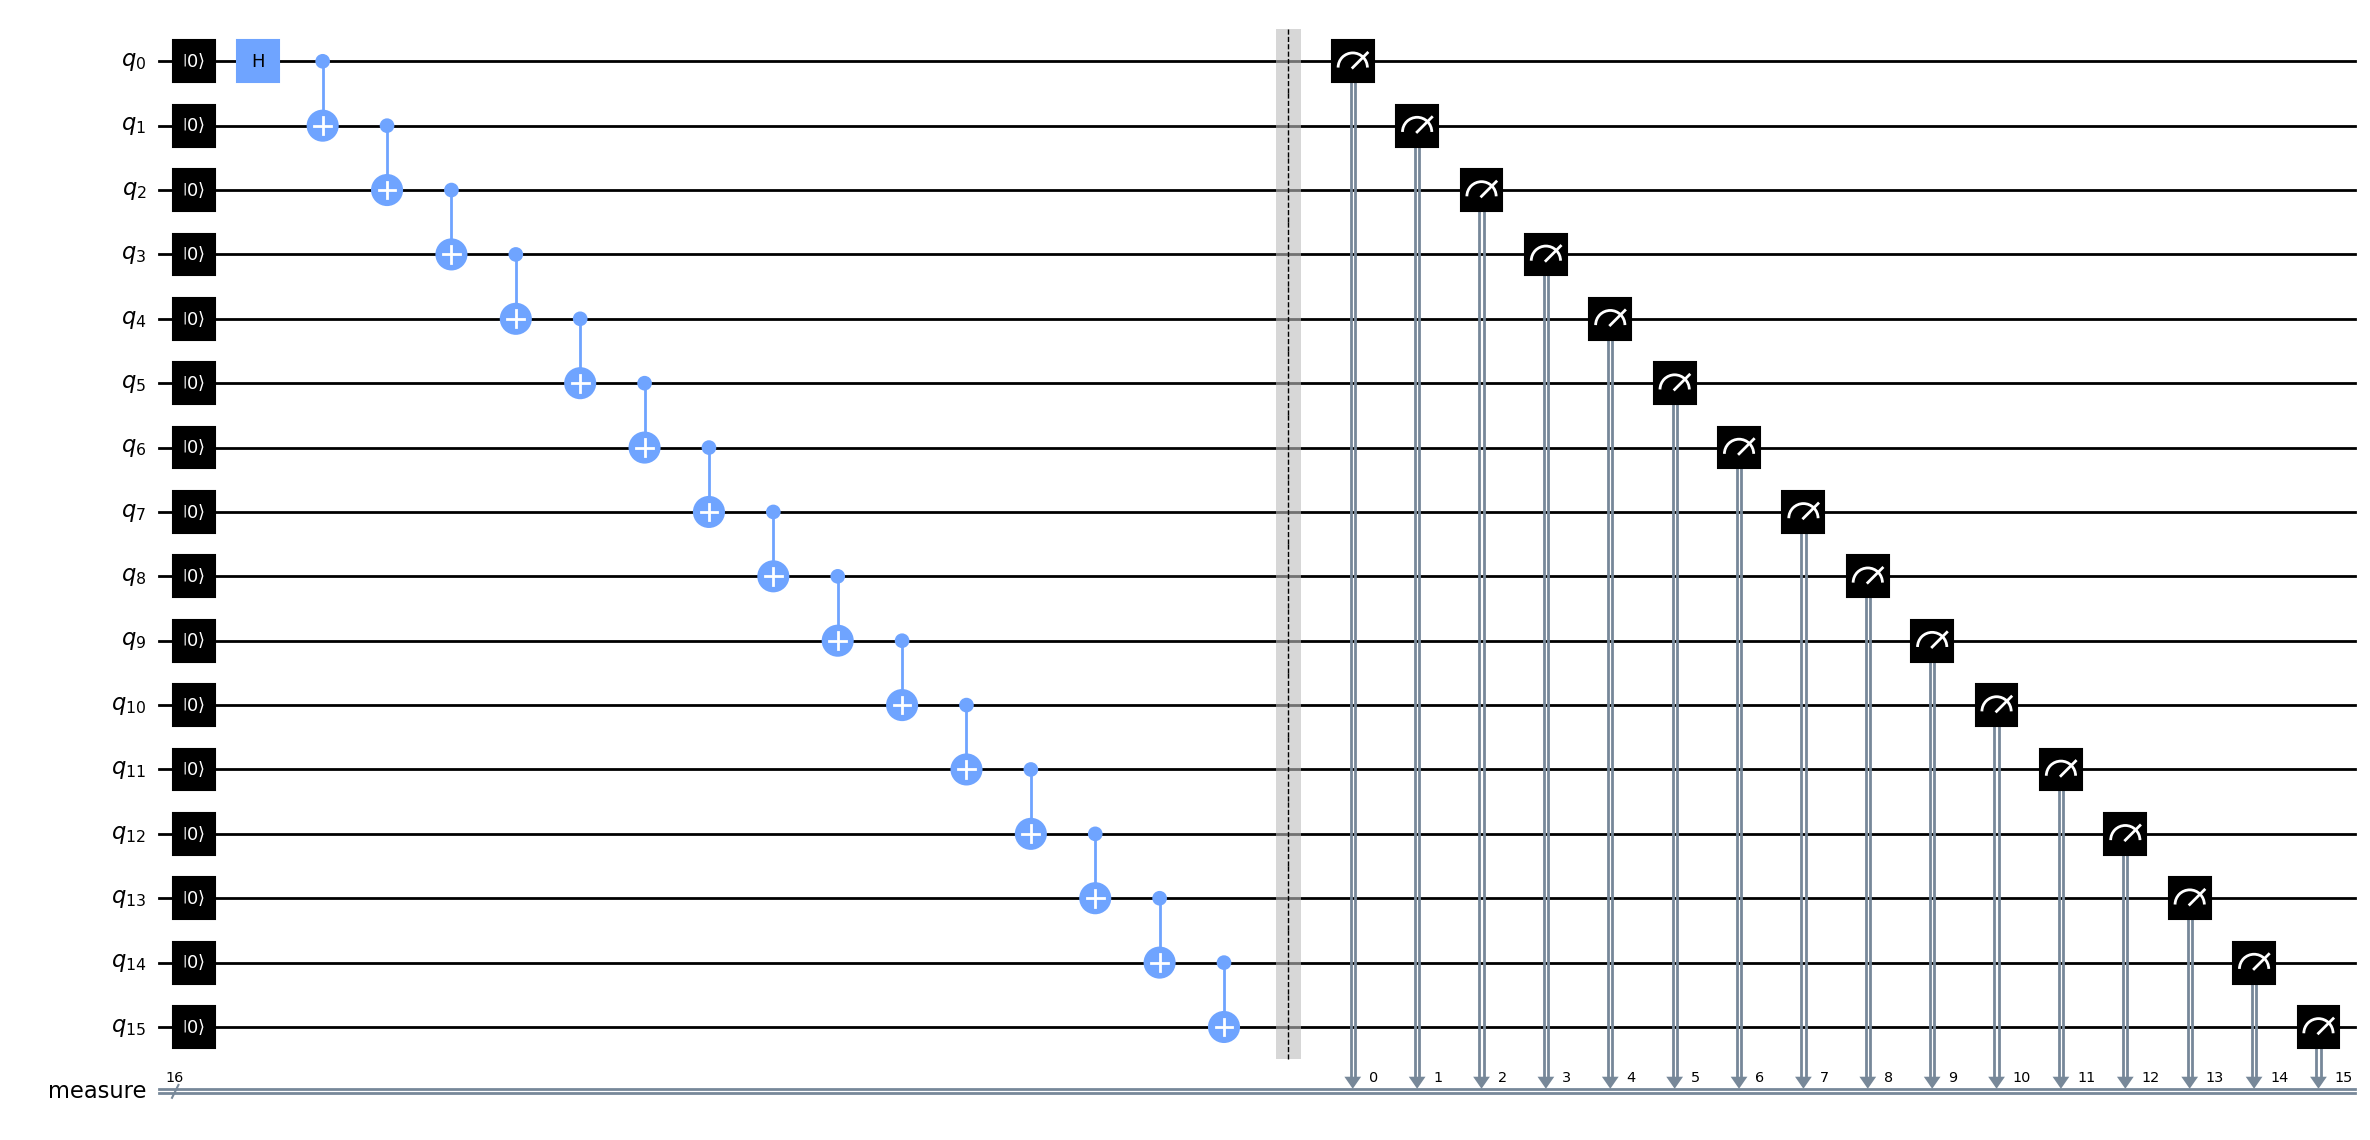

In [5]:
linear['circuit'] = linear_complexity_GHZ(N)
linear['circuit'].draw(output='mpl', fold=-1)

### Generate Logaritmic Complexity Circuits for $|\text{GHZ}_{2^m}\rangle$

In [6]:
def _log_complexity_GHZ(m: int) -> QuantumCircuit:
  if not isinstance(m, int):
    raise TypeError("Only integer arguments accepted.")
  if m < 0:
    raise ValueError("`m` must be at least 0 (evaluated 2^m).")

  if m == 0:
    c = QuantumCircuit([Qubit()])
    c.reset(0)
    c.h(0)
  else:
    c = _log_complexity_GHZ(m - 1)
    for i in range(c.num_qubits):
      c.add_bits([Qubit()])
      new_qubit_index = c.num_qubits - 1
      c.reset(new_qubit_index)
      c.cx(i, new_qubit_index)
  return c

### Generate Logaritmic Complexity Circuits for $|\text{GHZ}_N\rangle$

In [7]:
def log_complexity_GHZ(N: int) -> QuantumCircuit:
  if not isinstance(N, int):
    raise TypeError("Only an integer argument is accepted.")
  if N < 1:
    raise ValueError("There must be one or more qubits.")

  m = math.ceil(math.log2(N))
  num_qubits_to_erase = 2**m - N
  old_circuit = _log_complexity_GHZ(m=m)
  new_num_qubits = old_circuit.num_qubits - num_qubits_to_erase
  new_circuit = QuantumCircuit(new_num_qubits)
  for gate in old_circuit.data:
    qubits_affected = gate.qubits
    if all(old_circuit.find_bit(qubit).index < new_num_qubits for qubit in qubits_affected):
      new_circuit.append(gate[0], [old_circuit.find_bit(qubit).index for qubit in qubits_affected])
  new_circuit.measure_active()
  return new_circuit


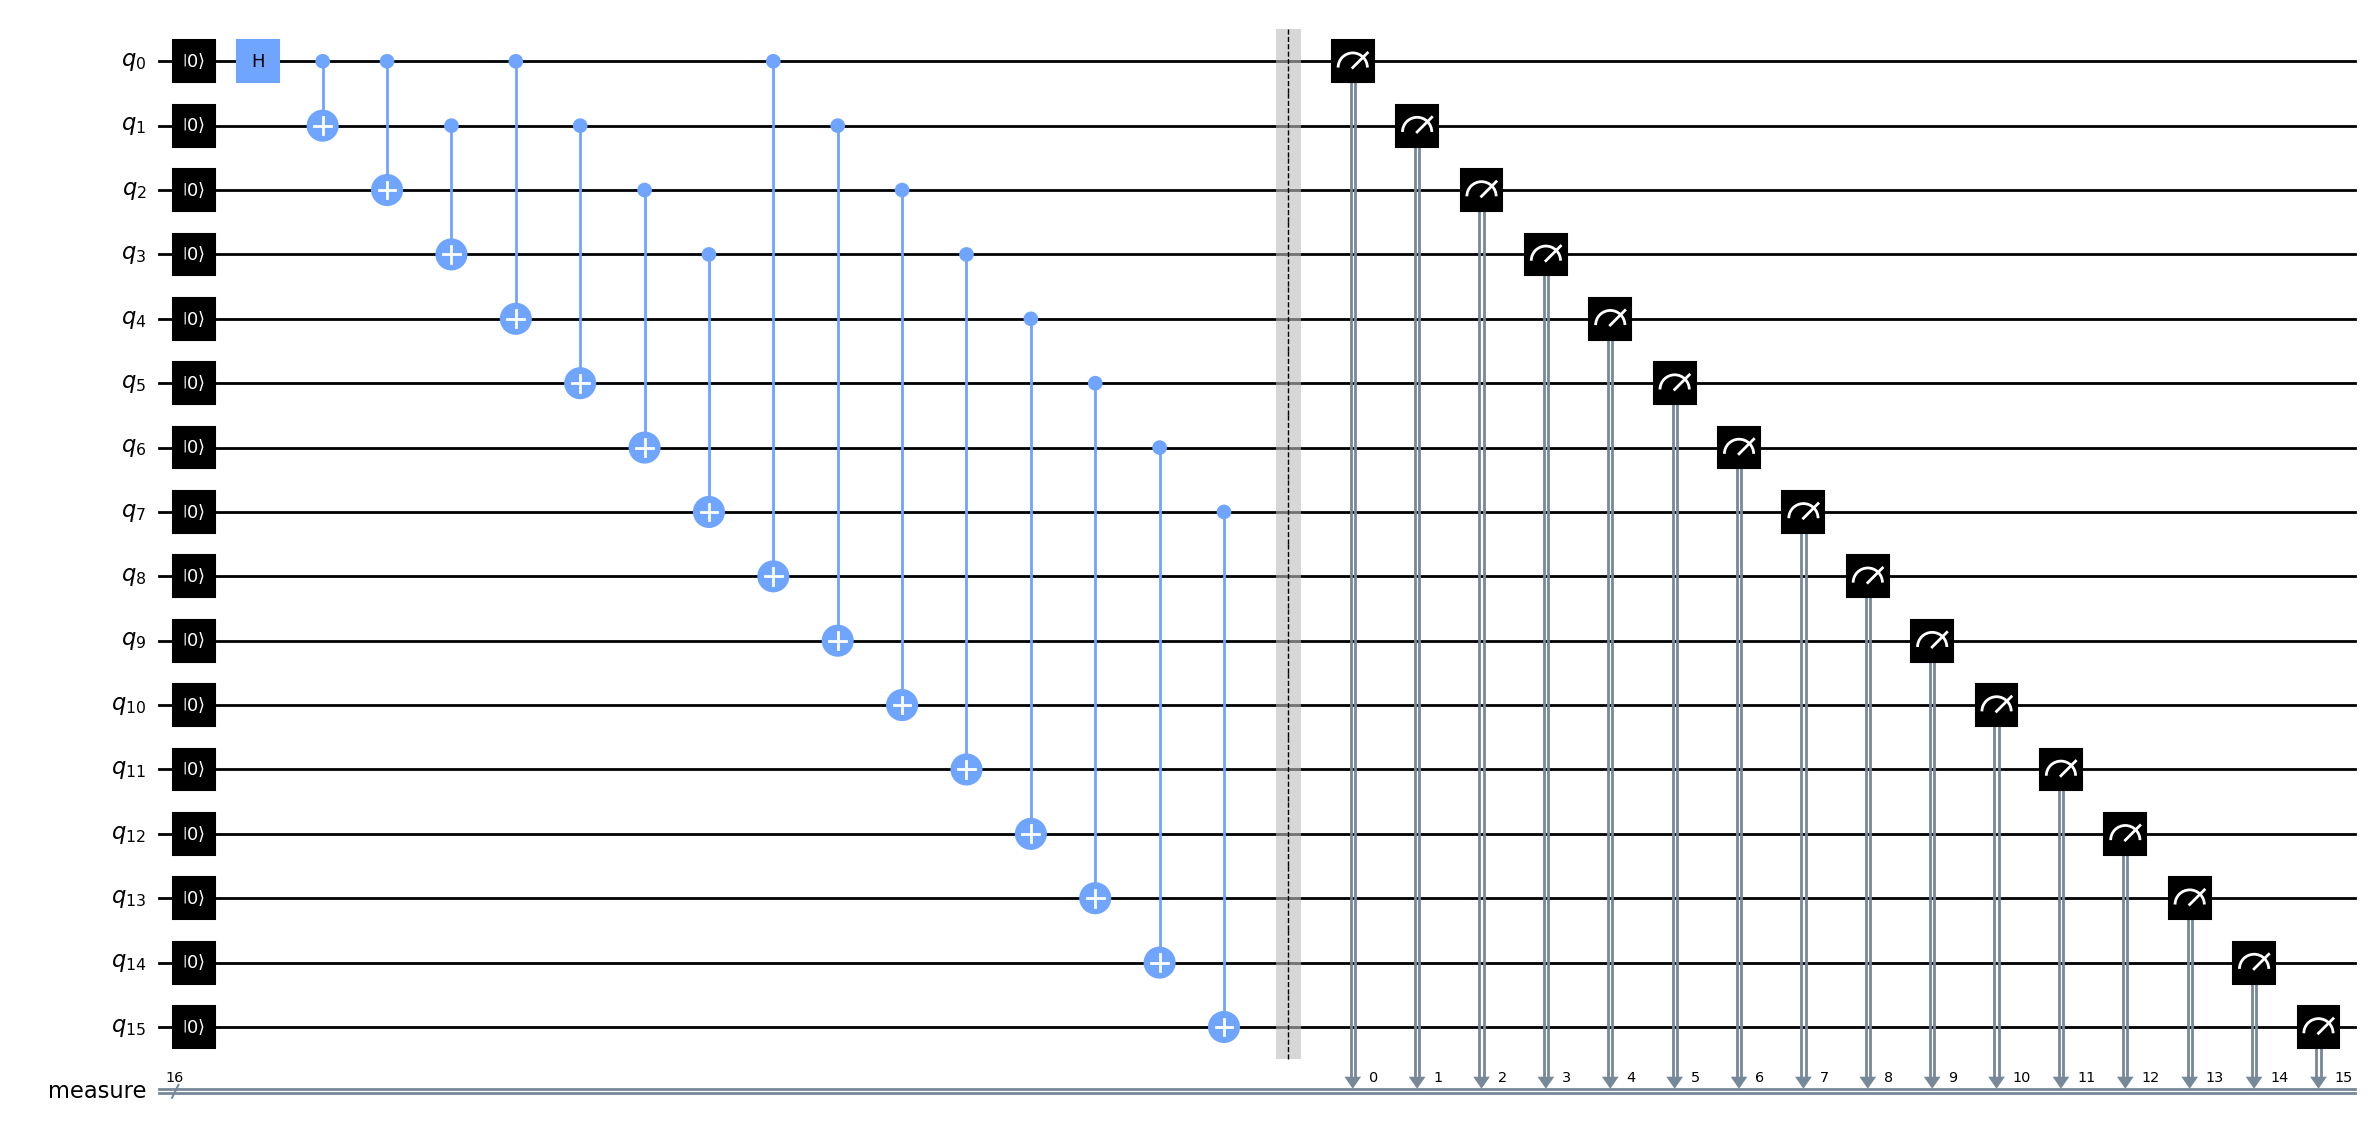

In [8]:
log['circuit'] = log_complexity_GHZ(N)
log['circuit'].draw(output='mpl', fold=-1)

---

## Quantum Simulation & Results

### Create Simulator Jobs

In [9]:
linear['job'] = execute(linear['circuit'], simulator, shots=shots)
log['job'] = execute(log['circuit'], simulator, shots=shots)

### Execution Histograms

#### Linear

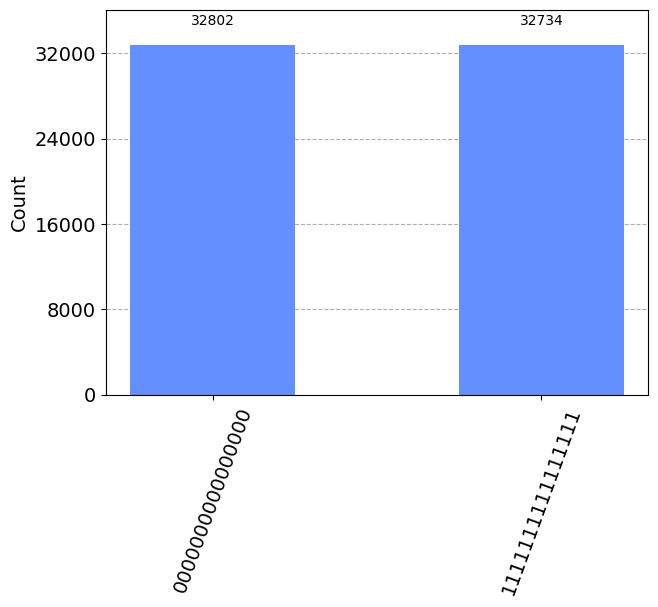

In [10]:
linear['result'] = linear['job'].result()
plot_histogram(linear['result'].get_counts())

#### Logaritmic

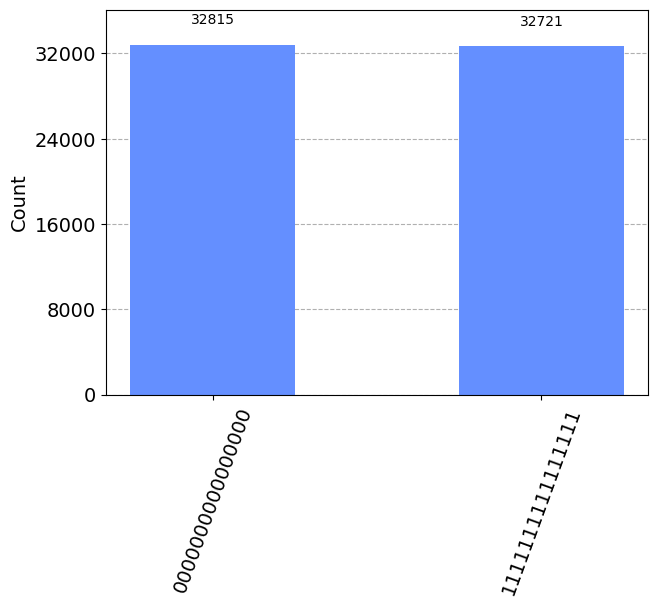

In [11]:
log['result'] = log['job'].result()
plot_histogram(log['result'].get_counts())

---

## Error Analysis

### Linear Error Percentage

##### State $|0\rangle$

In [12]:
linear['error']['0'] = abs((linear['result'].get_counts()['0' * N] - isps) / isps)
Latex(f"""\\begin{{equation*}}{linear['error']['0'] * 100}\%\\end{{equation*}}""")


<IPython.core.display.Latex object>

##### State $|1\rangle$

In [13]:
linear['error']['1'] = abs((linear['result'].get_counts()['1' * N] - isps) / isps)
Latex(f"""\\begin{{equation*}}{linear['error']['1'] * 100}\%\\end{{equation*}}""")

<IPython.core.display.Latex object>

### Logarithmic Error Percentage

#### State $|0\rangle$

In [14]:
log['error']['0'] = abs((log['result'].get_counts()['0' * N] - isps) / isps)
Latex(f"""\\begin{{equation*}}{log['error']['0'] * 100}\%\\end{{equation*}}""")

<IPython.core.display.Latex object>

#### State $|1\rangle$

In [15]:
log['error']['1'] = abs((log['result'].get_counts()['1' * N] - isps) / isps)
Latex(f"""\\begin{{equation*}}{log['error']['1'] * 100}\%\\end{{equation*}}""")

<IPython.core.display.Latex object>

---

## Speed-Up Analysis

### Run-Times

#### Linear

In [16]:
linear['time'] = linear['result'].time_taken
Latex(f"""\\begin{{equation*}}{linear['time']}\\space\\text{{seconds}}\\end{{equation*}}""")

<IPython.core.display.Latex object>

#### Log

In [17]:
log['time'] = log['result'].time_taken
Latex(f"""\\begin{{equation*}}{log['time']}\\space\\text{{seconds}}\\end{{equation*}}""")

<IPython.core.display.Latex object>

### Amdahl's Law

#### Parallel Portion

In [18]:
S_latency = linear['time'] / log['time']
P = (N * (1 - (1 / S_latency))) / (N - 1)
Latex(f"""\\begin{{equation*}}
    P = \\dfrac{{N\\left(1 - \\dfrac{{1}}{{S_\\text{{latency}}}}\\right)}}{{N - 1}} = \\dfrac{{{N}\\left(1 - \\dfrac{{1}}{{{S_latency}}}\\right)}}{{{N - 1}}} = {P * 100}\%
    \\end{{equation*}}
  """)

<IPython.core.display.Latex object>

#### Sequential Portion

In [19]:
S_EQ = 1 - P
Latex(f"""\\begin{{equation*}}S_\\text{{EQ}} = 1 - P = {S_EQ * 100}\%\\end{{equation*}}""")

<IPython.core.display.Latex object>

---

## References

1. [arXiv:1807.05572](https://arxiv.org/abs/1807.05572)